In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import scipy
import os
import pandas as pd
import shap

os.environ["CUDA_VISIBLE_DEVICES"]="5"

device = torch.device("cpu")

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
weight_path = "ResNet18"
model.load_state_dict(torch.load(weight_path, map_location=device))
model = model.to(device)
model.eval()


# LOAD TRAIN DATA
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_batch_size = 100
data_dir = "/export/gaon1/data/jteneggi/data/malaria/trophozoite"
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform)
dataloader = torch.utils.data.DataLoader(train_data, batch_size = train_batch_size, shuffle = True, num_workers = 0)
train_loader = iter(dataloader)
X, Y = next(train_loader)
X = X.to(device).detach()
# DEFINE MASK BACKGROUND WITH AVERAGE OF TRAINING SET
background = torch.mean(X, dim = 0).detach()

gradexp = shap.GradientExplainer(model, X)

Explaining image 0
Execution completed in 579.8661 s
Explaining image 1
Execution completed in 594.8987 s


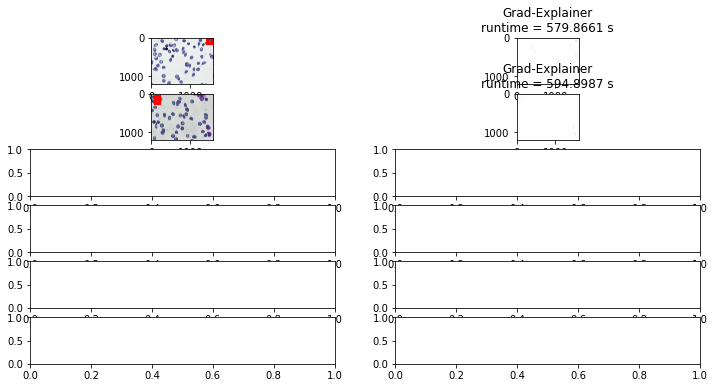

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

L = 2
fig = plt.figure(figsize=(12, L * 3))
axes = fig.subplots(6, 2)

df_training = pd.read_json("/export/gaon1/data/jteneggi/data/malaria/training.json")
# ADD IMAGE_NAME COLUMN TO DATAFRAME
image_names = []
for i, row in df_training.iterrows():
    image_names.append(os.path.basename(row["image"]["pathname"]))
df_training["image_name"] = image_names

true_positives = np.load("true_positives.npy", allow_pickle=True)
for i, image in enumerate(np.random.choice(true_positives.item().get("1"), size=L, replace=False)):
    print("Explaining image %d" % i)
    img = Image.open(image)
    ax = axes[i, 0]
    ax.imshow(img)
    image_name = os.path.basename(image)
    query = df_training.loc[df_training["image_name"] == image_name]
    for j, row in query.iterrows():
        cells = row["objects"]
        for cell in cells:
            cell_class = cell["category"]
            if cell_class == "trophozoite":
                bbox = cell["bounding_box"]
                upper_left_r = bbox["minimum"]["r"]
                upper_left_c = bbox["minimum"]["c"]
                lower_right_r = bbox["maximum"]["r"]
                lower_right_c = bbox["maximum"]["c"]
                w = np.abs(lower_right_c - upper_left_c)
                h = np.abs(lower_right_r - upper_left_r)
                # Create a Rectangle patch
                rect = patches.Rectangle((upper_left_c,upper_left_r),w,h,linewidth=3,edgecolor='r',facecolor='none')
                # Add the patch to the Axes
                ax.add_patch(rect)
    torch_image = transform(img)
    input = torch_image.view(-1, 3, 1200, 1600)
    nsamples = 200
    t0 = time.time()
    gradexp_shapley_values, gradexp_indexes = gradexp.shap_values(input, ranked_outputs = 2, nsamples = nsamples)
    tf = time.time()
    gradexp_runtime = round(tf - t0, 6)
    gradexp_saliency = gradexp_shapley_values[0][0].sum(0)
    abs_values = np.abs(gradexp_saliency.flatten())
    max_val = np.nanpercentile(abs_values, 99.9)
    # print saliency map
    axes[i, 1].imshow(gradexp_saliency, cmap='bwr', vmin = -max_val, vmax = max_val)
    axes[i, 1].set_title('Grad-Explainer\nruntime = %.4f s' % gradexp_runtime)
    print('Execution completed in %.4f s' % (gradexp_runtime))